# South German Credit: Classifying Debtors with Machine Learning

This research is mainly about:  
1. Doing some in-depth exploratory data analysis after simple preprocessing.
2. Doing further feature engineering based on the discovery in EDA.
3. Using Synthetic Minority Over-Sampling Technique (SMOTE), Random Over-sampling (ROS), and SMOTETomek (SMOTEK), to try solving the imbalanced amount the two risk types; with the RandomForestClassifier, trianed on SMOTE, ROS, SMOTETomek (SMOTEK), and normal set, and tested on the same imbalanced normal hold-out set to see the feasibility of the three oversampling method. We will choose the better method for dealing with this dataset.


The data set comes from UCI repository, where no description about this data (meaning of each features, or related researches) is given.    

I decide to do some researches on my own, referring to some simple but practical methods applied to the same data on Kaggle.  
Note that there are some differneces betwwen the data found on the two websites.

In [1]:
# Basic Tools
import numpy as np
import pandas as pd
import math
import itertools as it
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
import random

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

# Classifiers
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Other machine learning tools
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, r2_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as sps 
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
import itertools
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek

In [2]:
dta = pd.read_table('german_credit_data.csv', sep = ',', header = 0)
dt = dta.copy()

In [14]:
dt['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [13]:
dt['Age'][dt[['Age']].idxmax()]

330    75
Name: Age, dtype: int64

# <a id='1'> 1 Data Matnipulation

Instructed by original instruction file: read_SouthGermanCredit.R:

In [4]:
# Assign a new column of ID.
dt = dt.rename(columns={'Unnamed: 0':'ID'})

## <a id='1.1'> 1.1 Filling the Missing Values

In [5]:
df = dt.copy()

In [8]:
df.isnull().index

RangeIndex(start=0, stop=1000, step=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [7]:
cols = ['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']
txt_v = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
num_v = ['Age', 'Job', 'Credit amount', 'Duration']

I think the value of 'Saving accounts' has much to do with 'Duration' (repaying?) and 'Purpose', so I want to fill the missing 'Saving accounts' according to the corresponding values of these two variables.

For some categorical columns, I convert text to integers.

In [9]:
for col in ["Sex", "Purpose", "Risk"]:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,1,2,own,NaN,little,1169,6,5,1
1,1,22,0,2,own,little,moderate,5951,48,5,0
2,2,49,1,1,own,little,NaN,2096,12,3,1
3,3,45,1,2,free,little,little,7882,42,4,1
4,4,53,1,2,free,little,little,4870,24,1,0


In [35]:
df[['Checking account']].loc[0]


Checking account    little
Name: 0, dtype: object

In [9]:
# 1 Saving accounts

for i in range(len(df)):
    if df['Saving accounts'].iloc[i] == "little":
        df['Saving accounts'].iloc[i] = 1
    elif df['Saving accounts'].iloc[i] == "moderate":
        df['Saving accounts'].iloc[i] = 2
    elif df['Saving accounts'].iloc[i] == "quite rich":
        df['Saving accounts'].iloc[i] = 3
    elif df['Saving accounts'].iloc[i] == "rich":
        df['Saving accounts'].iloc[i] = 4
    else:
        df['Saving accounts'].iloc[i] = 1
        
# 2 Housing

for i in range(len(df)):
    if df['Housing'].iloc[i] == "free":
        df['Housing'].iloc[i] = 0
    elif df['Housing'].iloc[i] == "rent":
        df['Housing'].iloc[i] = 1
    elif df['Housing'].iloc[i] == "own":
        df['Housing'].iloc[i] = 2

# 3 Checking account

for i in range(len(df)):
    if df['Checking account'].iloc[i] == "little":
        df['Checking account'].iloc[i] = 1
    elif df['Checking account'].iloc[i] == "moderate":
        df['Checking account'].iloc[i] = 2
    elif df['Checking account'].iloc[i] == "quite rich":
        df['Checking account'].iloc[i] = 3
    elif df['Checking account'].iloc[i] == "rich":
        df['Checking account'].iloc[i] = 4
    else:
        if df['Risk'].iloc[i] == 1:
            df['Checking account'].iloc[i] = 2
        if df['Risk'].iloc[i] == 0:
            df['Checking account'].iloc[i] = 0

In [10]:
df.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,1,2,2,1,1,1169,6,5,1
1,1,22,0,2,2,1,2,5951,48,5,0
2,2,49,1,1,2,1,2,2096,12,3,1
3,3,45,1,2,0,1,1,7882,42,4,1
4,4,53,1,2,0,1,1,4870,24,1,0


In [11]:
# Brief Summary & Statistics
Summary = pd.DataFrame(index = df.columns)
Summary['Dtype'] = df.dtypes.values
Summary['Non_NA_records'] = df.count().values
Summary['Non_zero_records'] = df.astype(bool).sum(axis=0)
Summary['Populated'] = round(df.count()/df.shape[0]*100, 2)
Summary['Unique_values'] = df.nunique().values
Summary['Mean'] = round(df.mean(),2)
Summary['Std'] = round(df.std(),2)

Summary

,Dtype,Non_NA_records,Non_zero_records,Populated,Unique_values,Mean,Std
ID,int64,1000,999,100.0,1000,499.50,288.82
Age,int64,1000,1000,100.0,53,35.55,11.38
Sex,int32,1000,690,100.0,2,0.69,0.46
Job,int64,1000,978,100.0,4,1.90,0.65
Housing,object,1000,892,100.0,3,1.60,0.67
Saving accounts,object,1000,1000,100.0,4,1.37,0.81
Checking account,object,1000,954,100.0,4,1.76,0.81
Credit amount,int64,1000,1000,100.0,921,3271.26,2822.74
Duration,int64,1000,1000,100.0,33,20.90,12.06
Purpose,int32,1000,903,100.0,8,2.88,1.98


In this case, we have confirmed the categorical and numerical variables.  
Thus we use two lists to save them.

# <a id='2'> 2 Exploratory Analysis

In [12]:
sns.set(style = "darkgrid")

## <a id='2.1'> 2.1 Credit Risk in Data

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

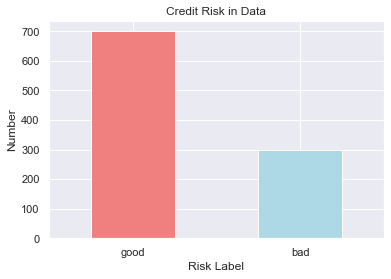

In [13]:
cr = dt['Risk'].value_counts().plot(kind='bar',color = ['lightcoral', 'lightblue'])
plt.xlabel('Risk Label')
plt.ylabel('Number')
plt.title('Credit Risk in Data')
plt.xticks(rotation=360)

## <a id='2.2'>2.2 Variable Distributions

### <a id='2.2.1'>2.2.1 Categorial Variable Distributions 

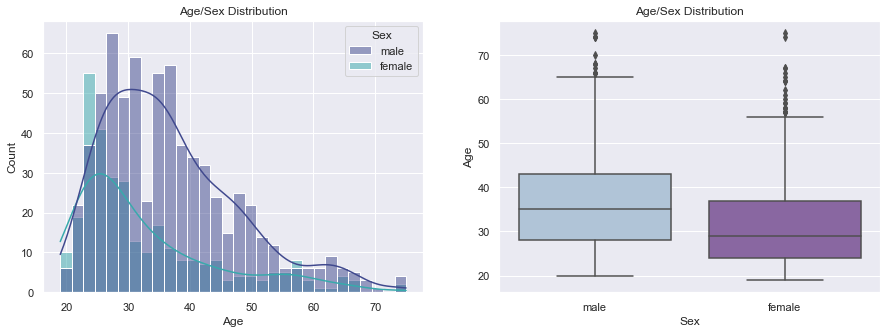

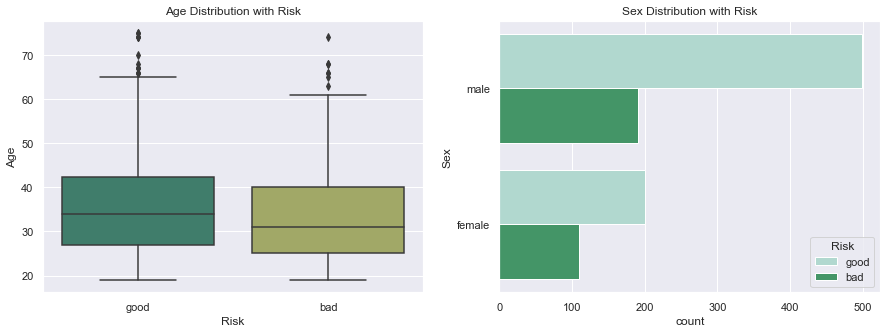

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(dt, x='Age', bins=30, hue="Sex", ax=ax[0], palette = 'mako', kde = True).set_title("Age/Sex Distribution");
sns.boxplot(data=dt, x="Sex", y="Age", ax=ax[1], palette = 'BuPu').set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=dt, x='Risk', y='Age', ax=ax[0], palette = 'gist_earth').set_title("Age Distribution with Risk");
sns.countplot(data=dt, y="Sex", hue="Risk", ax=ax[1], palette = 'BuGn').set_title("Sex Distribution with Risk");

Text(0.5, 1.0, 'Duration Distribution with Risk')

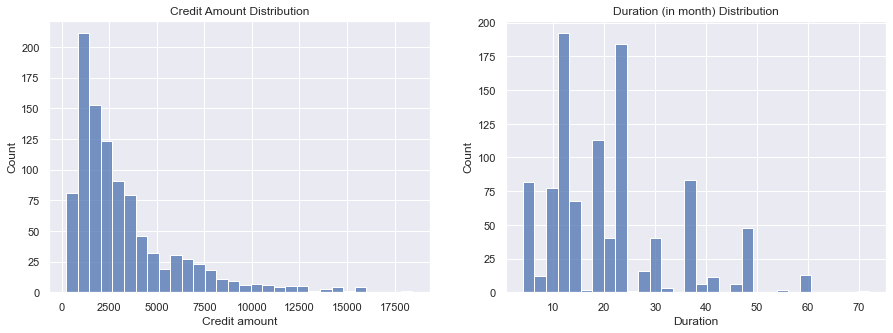

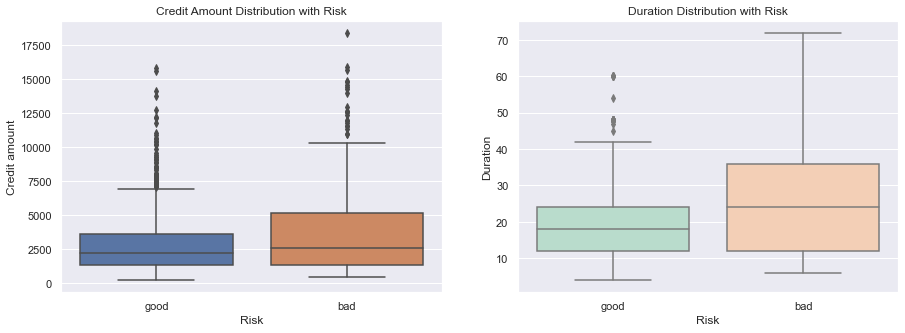

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(dt, x='Credit amount', bins=30, ax=ax[0]).set_title("Credit Amount Distribution")
sns.histplot(dt, x='Duration', bins=30, ax=ax[1]).set_title("Duration (in month) Distribution")

fig, ax = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(data=dt, x='Risk', y='Credit amount', ax=ax[0]).set_title("Credit Amount Distribution with Risk")
sns.boxplot(data=dt, x='Risk', y='Duration', ax=ax[1], palette = 'Pastel2').set_title("Duration Distribution with Risk")

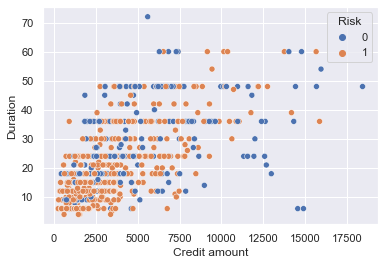

In [16]:
sns.scatterplot(y = 'Duration', x = 'Credit amount', data = df, hue = 'Risk')

Text(0.5, 1.0, 'Duration Distribution with Risk')

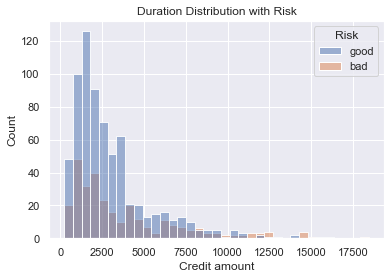

In [17]:
sns.histplot(data=dt, x='Credit amount', hue = 'Risk', ).set_title("Duration Distribution with Risk")

From the bar plot above, these data are skewed to right to different extent.  
To show the presentce of outliers, I use a box plot to check the values of these three numerical variables.  

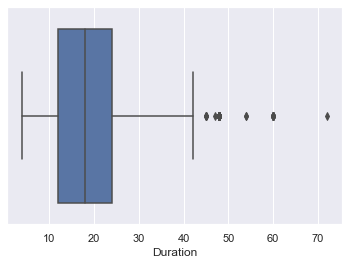

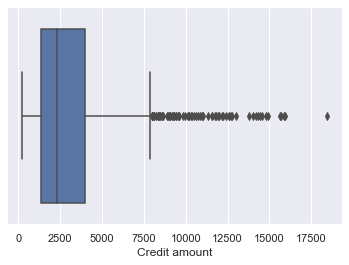

In [18]:
for i in ['Duration', 'Credit amount']:
    sns.boxplot(dt[i])
    plt.show()

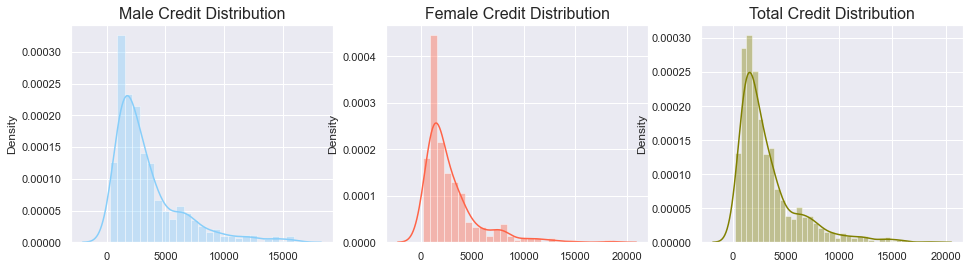

In [19]:
# Distribution of Credit_Amount for each Gender
male_credit = df["Credit amount"].loc[df["Sex"] == 1].values
female_credit = df["Credit amount"].loc[df["Sex"] == 0].values
total_credit = df['Credit amount'].values

fig, ax = plt.subplots(1, 3, figsize=(16,4))

sns.distplot(male_credit, ax=ax[0], color = 'lightskyblue')
ax[0].set_title("Male Credit Distribution", fontsize=16)
sns.distplot(female_credit, ax=ax[1], color="tomato")
ax[1].set_title("Female Credit Distribution", fontsize=16)
sns.distplot(total_credit, ax=ax[2], color="olive")
ax[2].set_title("Total Credit Distribution", fontsize=16)
plt.show()

## <a id='2.3'>2.3 Variable Distributions by Risk Type

In [20]:
good_credit = dt[dt['Risk'] == 'good']; bad_credit = dt[dt['Risk'] == 'bad']

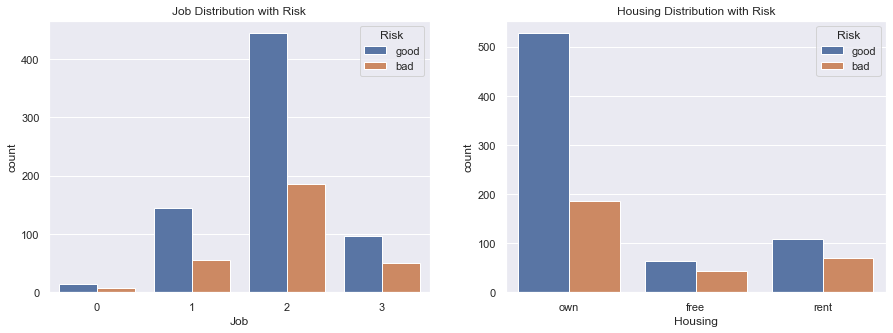

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=dt, x="Job", hue="Risk", ax=ax[0]).set_title("Job Distribution with Risk");
sns.countplot(data=dt, x="Housing", hue="Risk", ax=ax[1]).set_title("Housing Distribution with Risk");

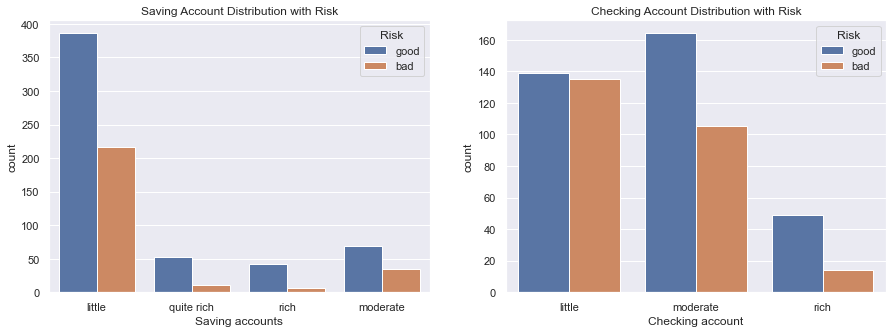

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=dt, x="Saving accounts", hue="Risk", ax=ax[0]).set_title("Saving Account Distribution with Risk");
sns.countplot(data=dt, x="Checking account", hue="Risk", ax=ax[1]).set_title("Checking Account Distribution with Risk");

Purpose Distribution by Risk

Text(0.5, 1.0, 'Purpose Distribution by Risk')

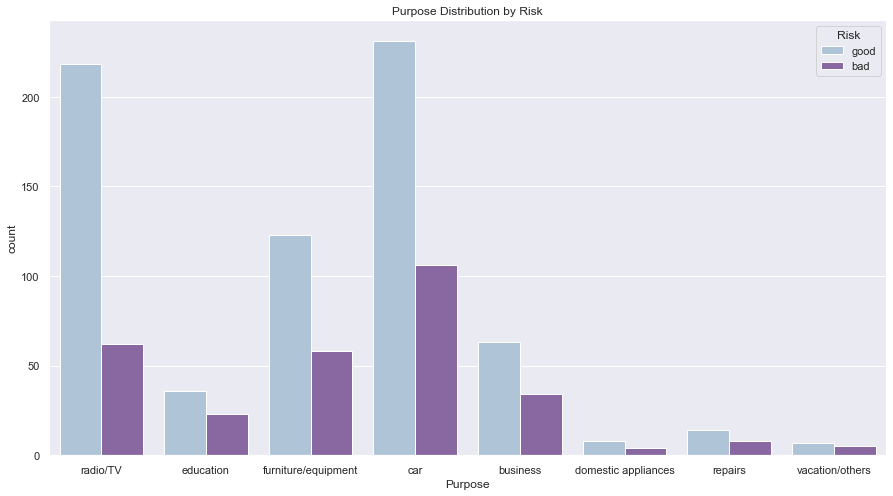

In [23]:
plt.figure(figsize = (15, 8))
sns.countplot(data=dt, x="Purpose", hue="Risk", palette = 'BuPu').set_title("Purpose Distribution by Risk")

In [24]:
dt['Purpose'].value_counts().index

Index(['car', 'radio/TV', 'furniture/equipment', 'business', 'education',
       'repairs', 'vacation/others', 'domestic appliances'],
      dtype='object')

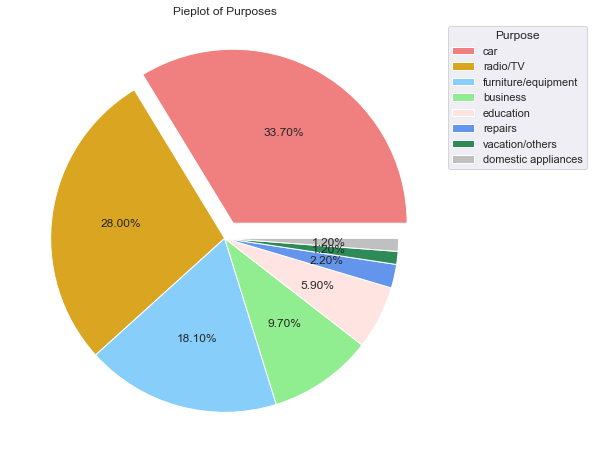

In [25]:
#Pieplot for Purposes
y = dt['Purpose'].value_counts()
plt.figure(figsize = (10, 8))
plt.pie(y, 
        colors = ["lightcoral", "goldenrod", "lightskyblue", "lightgreen", "mistyrose", "cornflowerblue", "seagreen", "silver"], 
        explode = [0.1, 0, 0, 0, 0, 0, 0, 0], 
        autopct='%.2f%%', 
       )
plt.legend(labels = dt['Purpose'].value_counts().index, title = 'Purpose', bbox_to_anchor=(1, 1))
plt.title("Pieplot of Purposes")
plt.show()

## <a id='2.4'> 2.4. Pair Plots </a>

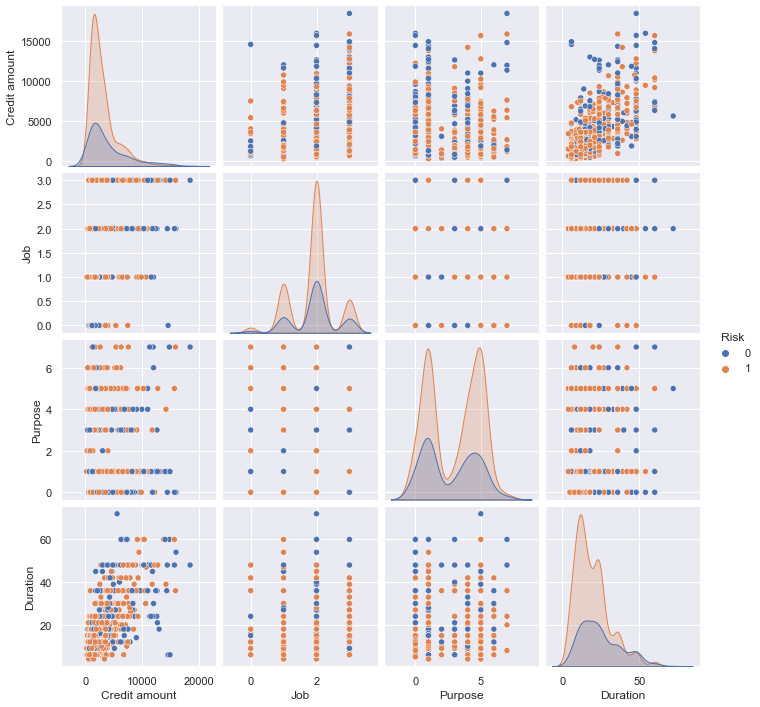

In [26]:
sns.pairplot(df[['Credit amount','Job' , 'Purpose', 'Duration', 'Risk']], hue = 'Risk');

# <a id='3'> 3. Feature Engineering

In this section, I will use the origin set whose categorical variables has been converted to numerical.

In [27]:
crdata = df.copy()

In [28]:
crdata.describe()

,ID,Age,Sex,Job,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,0.690000,1.904000,3271.258000,20.903000,2.878000,0.700000
std,288.819436,11.375469,0.462725,0.653614,2822.736876,12.058814,1.978138,0.458487
min,0.000000,19.000000,0.000000,0.000000,250.000000,4.000000,0.000000,0.000000
25%,249.750000,27.000000,0.000000,2.000000,1365.500000,12.000000,1.000000,0.000000
50%,499.500000,33.000000,1.000000,2.000000,2319.500000,18.000000,3.000000,1.000000
75%,749.250000,42.000000,1.000000,2.000000,3972.250000,24.000000,5.000000,1.000000
max,999.000000,75.000000,1.000000,3.000000,18424.000000,72.000000,7.000000,1.000000


## <a id='3.0'> 3.0 Building New Variables

### <a id='3.0.1'>3.0.1 Adding New Variables

In [29]:
all_v = num_v + txt_v
n_v = ['Credit amount', 'Duration']

In [30]:

# 1 Ratio Variables
def ratio_v(data, v):
    for i in v:
        for j in v:
            if i < j:
                tmp_name = f'{i}/{j}'
                print(tmp_name)
                data[tmp_name] = data[i]/dt[j]
    return data.shape


In [31]:
ratio_v(crdata, n_v)

Credit amount/Duration


(1000, 12)

In [32]:
# 2 Add log of numeric fields
for col in n_v:
    crdata.loc[:, f'{col}_log'] = crdata[col].apply(lambda x: -1000 if pd.isna(np.log(1+x)) else np.log(1+x))
crdata.shape 

(1000, 14)

In [33]:
# 3 Polynomial Features
from sklearn import preprocessing
def polynomial_features(dataframe, num_cols):
    df = dataframe.loc[:, num_cols].copy()
    normal_num = df.shape[1]
    pf = preprocessing.PolynomialFeatures(
        degree=2,
        interaction_only=False,
        include_bias=False
    )
    pf.fit(df)
    poly_feats = pf.transform(df)
    poly_feats = poly_feats[:, normal_num:]
    poly_columns = pf.get_feature_names(df.columns)[normal_num:]
    poly_columns = [col.replace(' ', '--*--').replace('^2', '--^2') for col in poly_columns]
    df_poly = pd.DataFrame(poly_feats, columns=poly_columns)
    return df_poly

In [34]:
poly_df = polynomial_features(crdata, n_v)
for col in poly_df.columns:
    crdata[col] = poly_df[col].tolist()
crdata.shape


(1000, 17)

In [35]:
crdata['Saving + Checking'] = crdata['Saving accounts'] + crdata['Checking account']

In [36]:
crdata_plus = crdata.copy()
crdata_plus

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Credit amount/Duration,Credit amount_log,Duration_log,Credit--*--amount--^2,Credit--*--amount--*--Duration,Duration--^2,Saving + Checking
0,0,67,1,2,2,1,1,1169,6,5,1,194.833333,7.064759,1.945910,1366561.0,7014.0,36.0,2
1,1,22,0,2,2,1,2,5951,48,5,0,123.979167,8.691483,3.891820,35414401.0,285648.0,2304.0,3
2,2,49,1,1,2,1,2,2096,12,3,1,174.666667,7.648263,2.564949,4393216.0,25152.0,144.0,3
3,3,45,1,2,0,1,1,7882,42,4,1,187.666667,8.972464,3.761200,62125924.0,331044.0,1764.0,2
4,4,53,1,2,0,1,1,4870,24,1,0,202.916667,8.491055,3.218876,23716900.0,116880.0,576.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,0,1,2,1,2,1736,12,4,1,144.666667,7.459915,2.564949,3013696.0,20832.0,144.0,3
996,996,40,1,3,2,1,1,3857,30,1,1,128.566667,8.257904,3.433987,14876449.0,115710.0,900.0,2
997,997,38,1,2,2,1,2,804,12,5,1,67.000000,6.690842,2.564949,646416.0,9648.0,144.0,3
998,998,23,1,2,0,1,1,1845,45,5,0,41.000000,7.520776,3.828641,3404025.0,83025.0,2025.0,2


## <a id='3.2'>3.2 Correlation Matrix

To see what variables determine Risk more.

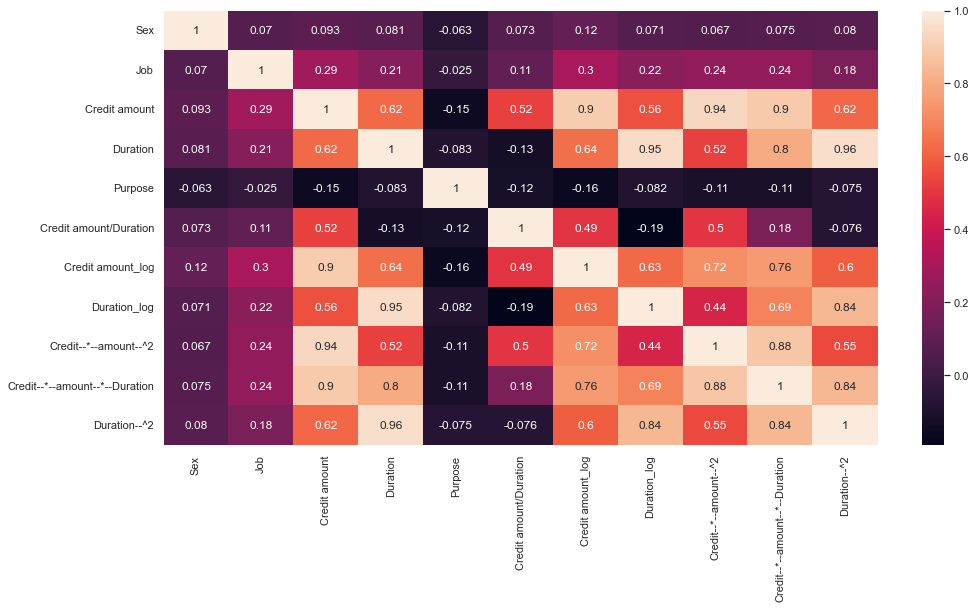

In [37]:
trntst_columns = list(crdata_plus.columns)
trntst_columns.remove('ID')
trntst_columns.remove('Age')
trntst_columns.remove('Risk')


plt.figure(figsize=(16,8))
sns.heatmap(crdata_plus[trntst_columns].corr(), annot=True)
plt.savefig('Heat.jpg')

''

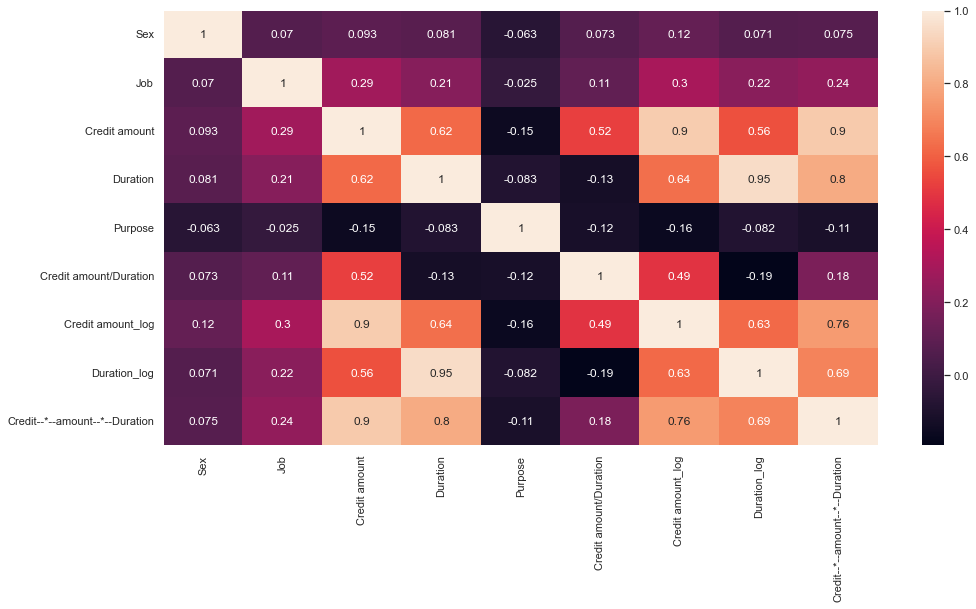

In [38]:

trntst_columns.remove('Duration--^2')
trntst_columns.remove('Credit--*--amount--^2')


plt.figure(figsize=(16,8))
sns.heatmap(crdata_plus[trntst_columns].corr(), annot=True)
plt.savefig('Heat.jpg')
''''''

## <a id='3.3'>3.3 Split the Dataset

In [39]:
X = crdata[trntst_columns].copy(); y = (crdata.copy())['Risk']

In [40]:
good_idx = crdata[crdata['Risk'] == 1].index
bad_idx = crdata[crdata['Risk'] == 0].index

In [41]:
test_size = 0.2
test_bad_idx = list(np.random.choice(bad_idx, round(len(bad_idx) * test_size), replace = False))
train_bad_idx = [i for i in bad_idx if i not in test_bad_idx]
test_good_idx = list(np.random.choice(good_idx, round(len(good_idx) * test_size), replace = False))
train_good_idx = [i for i in good_idx if i not in test_good_idx]


train_idx = train_bad_idx + train_good_idx
test_idx = test_bad_idx + test_good_idx
random.shuffle(train_idx); random.shuffle(test_idx)

print('train size', len(train_idx))
print('test size', len(test_idx))

X_train = X.iloc[train_idx]; y_train = y.iloc[train_idx].astype(float)
X_test = X.iloc[test_idx]; y_test = y.iloc[test_idx].astype(float)

train size 800
test size 200


In [42]:
#X_train, X_test, y_train, y_test = train_test_split(X[trntst_columns], y, test_size=0.9, random_state=0)

In [43]:
X_test

,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Credit amount/Duration,Credit amount_log,Duration_log,Credit--*--amount--*--Duration,Saving + Checking
632,1,2,2,1,2,1444,15,5,96.266667,7.275865,2.772589,21660.0,3
640,0,0,2,1,1,750,18,3,41.666667,6.621406,2.944439,13500.0,2
307,1,1,2,2,1,727,12,5,60.583333,6.590301,2.564949,8724.0,3
691,0,1,2,2,2,2631,15,6,175.400000,7.875499,2.772589,39465.0,4
788,1,2,0,1,2,6224,48,3,129.666667,8.736329,3.891820,298752.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0,2,2,1,0,4611,6,4,768.500000,8.436417,1.945910,27666.0,1
544,1,1,2,1,2,1255,12,1,104.583333,7.135687,2.564949,15060.0,3
494,1,1,1,1,1,2122,12,1,176.833333,7.660585,2.564949,25464.0,2
811,1,1,2,1,2,484,6,5,80.666667,6.184149,1.945910,2904.0,3


##  <a id='3.5'>3.5 SMOTE on the Training Set

In [44]:
scl = StandardScaler()

In [45]:
smt = SMOTE(random_state=0)
X_smt_train, y_smt_train = smt.fit_resample(X_train, y_train)
X_smt_train = scl.fit_transform(X_smt_train)

In [46]:
c = 0
for i in y_smt_train:
    if i == 1:
        c += 1
c

560

##  <a id='3.6'>3.6 ROS on the Training Set 

In [47]:
ros = RandomOverSampler(random_state=0, sampling_strategy='auto') 
X_ros_train, y_ros_train = ros.fit_resample(X_train, y_train)
X_ros_train = scl.fit_transform(X_ros_train)

In [48]:
len(X_ros_train)

1120

##  <a id='3.7'>3.7 SMOTETomek on the Training Set 

In [49]:
stt = SMOTETomek(random_state=0)  # 综合采样
X_stt_train, y_stt_train = stt.fit_resample(X_train, y_train)
X_stt_train = scl.fit_transform(X_stt_train)

In [50]:
np.shape(X_stt_train)

(910, 13)

In [51]:
c = 0
for i in y_stt_train:
    if i == 1:
        c += 1
c

455

# <a id='4'> 4 Modeling & Predicting

In this section, using the preprocessed data, I want to first try finding the best number of clusters (Credit Risk) for the data.  
Then I will use 4 cutting-edge classifiers for the modeling task.  
Finally, I will compare the four models and choose the one performs the best.

## <a id='4.1'> 4.1 Comparison by Random Forest

For training, we have the set for SMOTE method: X_smt_train and y_smt_train; and we have the set without SMOTE: X_train and y_train.  
For testing, we will test two models on the same X_test and y_test: this give the model trained by SMOTE-processed set a harsher training to truely test SMOTE and give them a better comparison. 

In [52]:
# Evaluation Methods
# Confusion Matrix & ROC Curve
def plot_cm(cm, classes,
                    normalize = True,
                    title='Confusion matrix',
                    cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def plot_rc(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [53]:
# RFC Parameter Grid
params = {'n_estimators': [101, 102, 103], 'max_depth': [13, 14, 15], 'max_leaf_nodes': [9, 10, 11]}

Using SMOTE Set

In [54]:
#SMOTE grid search
rf_smt = RandomForestClassifier()

gs_smt = GridSearchCV(rf_smt, params, cv = 5)

In [55]:
#SMOTE training
gs_smt.fit(X_smt_train, y_smt_train)

smt_estimator = gs_smt.best_estimator_

smt_p = gs_smt.best_params_

smt_estimator.fit(X_smt_train, y_smt_train)

print('The best parameters for RFC (SMOTE) is', smt_p)

The best parameters for RFC (SMOTE) is {'max_depth': 13, 'max_leaf_nodes': 11, 'n_estimators': 101}


In [56]:
test_smt = smt_estimator
#RandomForestClassifier(max_depth = smt_p['max_depth'], max_leaf_nodes = smt_p['max_leaf_nodes'], n_estimators = smt_p['n_estimators'])
smt_scores = cross_val_score(test_smt, X_smt_train, y_smt_train, scoring = 'accuracy')
print('The average accuracy on the SMOTE set is', smt_scores.mean())
print('The average training AUC score is', np.mean(cross_val_score(test_smt, X_smt_train, y_smt_train, scoring = 'roc_auc')))

The average accuracy on the SMOTE set is 0.8008928571428571
The average training AUC score is 0.886312181122449


In [57]:
#SMOTE testing
test_smt.fit(X_test, y_test)
y_pred_smt = test_smt.predict(X_test)

print('The testing accuracy of the SMOTE set is', accuracy_score(y_test, y_pred_smt))
print('The average testing AUC score is', cross_val_score(test_smt, X_test, y_test, scoring = 'roc_auc').mean())

The testing accuracy of the SMOTE set is 0.865
The average testing AUC score is 0.719047619047619


In [58]:
# True Negative Rate
TN = 0; TP = 0; FN = 0; FP = 0
for i in range(len(y_pred_smt)):
    if y_pred_smt[i] == 0:
        if y_test.iloc[i] == 0:
            TN += 1
        else:
            FN += 1
    else:
        if y_test.iloc[i] == 1:
            TP += 1
        else:
            FP +=1
print('The true negative rate is', TN/(TN + FP))
print('The true positive rate is', TP/(TP + FN))

The true negative rate is 0.6
The true positive rate is 0.9785714285714285


Using ROS set

In [59]:
rf_ros = RandomForestClassifier()

gs_ros = GridSearchCV(rf_ros, params, cv = 5)


#SMOTE training
gs_ros.fit(X_train, y_train)

ros_estimator = gs_ros.best_estimator_

ros_p = gs_ros.best_params_

ros_estimator.fit(X_train, y_train)

print('The best parameters for RFC (ROS) is', ros_p)

ros_estimator.score(X_train, y_train)


test_ros = RandomForestClassifier(max_depth = ros_p['max_depth'], max_leaf_nodes = ros_p['max_leaf_nodes'], 
                                n_estimators = ros_p['n_estimators'])
ros_scores = cross_val_score(rf_ros, X_train, y_train)
print('The average accuracy on the ROS training set is', ros_scores.mean())
print('The average AUC score is', np.mean(cross_val_score(rf_ros, X_train, y_train, scoring = 'roc_auc')))

#SMOTE testing
test_ros.fit(X_test, y_test)
y_pred_ros = test_ros.predict(X_test)

print('The average testing accuracy of the ROS set is', accuracy_score(y_test, y_pred_ros))
print('The average of AUC score on ROS set is', np.mean(cross_val_score(test_ros, X_test, y_test, cv = 2, scoring = 'roc_auc')))

The best parameters for RFC (ROS) is {'max_depth': 15, 'max_leaf_nodes': 10, 'n_estimators': 101}
The average accuracy on the ROS training set is 0.7825
The average AUC score is 0.7827938988095238
The average testing accuracy of the ROS set is 0.865
The average of AUC score on ROS set is 0.6857142857142857


In [60]:
# True Negative Rate
TN = 0; TP = 0; FN = 0; FP = 0
for i in range(len(y_pred_ros)):
    if y_pred_ros[i] == 0:
        if y_test.iloc[i] == 0:
            TN += 1
        else:
            FN += 1
    else:
        if y_test.iloc[i] == 1:
            TP += 1
        else:
            FP +=1
print('The true negative rate is', TN/(TN + FP))
print('The true positive rate is', TP/(TP + FN))

The true negative rate is 0.6
The true positive rate is 0.9785714285714285


Using SMOTETomek set

In [61]:
rf_stt = RandomForestClassifier()

gs_stt = GridSearchCV(rf_stt, params, cv = 5)


#SMOTE training
gs_stt.fit(X_train, y_train)

stt_estimator = gs_stt.best_estimator_

stt_p = gs_stt.best_params_

stt_estimator.fit(X_train, y_train)

print('The best parameters for RFC (STT) is', stt_p)


stt_scores = cross_val_score(rf_stt, X_train, y_train)
print('The average accuracy on the SMOTETomek training set is', stt_estimator.score(X_train, y_train))
print('The average AUC score is', cross_val_score(rf_stt, X_stt_train, y_stt_train, scoring = 'roc_auc').mean())

#SMOTE testing
test_stt = RandomForestClassifier(max_depth = stt_p['max_depth'], max_leaf_nodes = stt_p['max_leaf_nodes'], 
                                n_estimators = stt_p['n_estimators'])
test_stt.fit(X_test, y_test)
y_pred_stt = test_stt.predict(X_test)

print('The average testing accuracy of the SMOTETomek set is', accuracy_score(y_test, y_pred_stt))
print('The average of AUC score on STT set is', np.mean(cross_val_score(stt_estimator, X_test, y_test, cv = 2, scoring = 'roc_auc')))

The best parameters for RFC (STT) is {'max_depth': 14, 'max_leaf_nodes': 11, 'n_estimators': 103}
The average accuracy on the SMOTETomek training set is 0.82375
The average AUC score is 0.9183431952662723
The average testing accuracy of the SMOTETomek set is 0.88
The average of AUC score on STT set is 0.6935714285714285


In [62]:
# True Negative Rate
TN = 0; TP = 0; FN = 0; FP = 0
for i in range(len(y_pred_stt)):
    if y_pred_stt[i] == 0:
        if y_test.iloc[i] == 0:
            TN += 1
        else:
            FN += 1
    else:
        if y_test.iloc[i] == 1:
            TP += 1
        else:
            FP +=1
print('The true negative rate is', TN/(TN + FP))
print('The true positive rate is', TP/(TP + FN))

The true negative rate is 0.65
The true positive rate is 0.9785714285714285


Using None-SMOTE set

In [63]:
rf_norm = RandomForestClassifier()

gs_norm = GridSearchCV(rf_norm, params, cv = 5)

In [64]:
#training
gs_norm.fit(X_train, y_train)

norm_estimator = gs_norm.best_estimator_

norm_p = gs_norm.best_params_

norm_estimator.fit(X_train, y_train)

print('The best parameters for RFC (normal) is', norm_p)

The best parameters for RFC (normal) is {'max_depth': 13, 'max_leaf_nodes': 10, 'n_estimators': 103}


In [65]:
test_norm = RandomForestClassifier(max_depth = norm_p['max_depth'], max_leaf_nodes = norm_p['max_leaf_nodes'], 
                                n_estimators = norm_p['n_estimators'])
norm_scores = cross_val_score(rf_norm, X_train, y_train)
print('The average accuracy on the normal training set is', norm_scores.mean())
print('The average AUC score is', np.mean(cross_val_score(rf_smt, X_train, y_train, scoring = 'roc_auc')))

The average accuracy on the normal training set is 0.765
The average AUC score is 0.7779575892857143


In [66]:
#SMOTE testing
test_norm.fit(X_test, y_test)
y_pred_norm = test_norm.predict(X_test)

print('The average testing accuracy of the normal set is', accuracy_score(y_test, y_pred_norm))
print('The average AUC score is', np.mean(cross_val_score(test_norm, X_test, y_test, cv = 2, scoring = 'roc_auc')))

The average testing accuracy of the normal set is 0.855
The average AUC score is 0.6857142857142857


In [67]:
# True Negative Rate
TN = 0; TP = 0; FN = 0; FP = 0
for i in range(len(y_pred_norm)):
    if y_pred_norm[i] == 0:
        if y_test.iloc[i] == 0:
            TN += 1
        else:
            FN += 1
    else:
        if y_test.iloc[i] == 1:
            TP += 1
        else:
            FP +=1
print('The true negative rate is', TN/(TN + FP))
print('The true positive rate is', TP/(TP + FN))

The true negative rate is 0.55
The true positive rate is 0.9857142857142858


It is easy to find that after training on a SMOTE-processed set, testing performance of the RandomForestClassifier clearly improved. It also shows a comparatively lower overfitting and predicts the negative instances (bad credit) correctly better.  
So, we finally choose to use the Random Foest Classifier trained on the dataset after SMOTE.